In [1]:
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil
import json
from collections import defaultdict

In [2]:
data_path = '/work/creative_self_motivated/dataset/child_painting'
image_path = os.path.join(data_path, 'images')
label_path = os.path.join(data_path, 'labels')

train_img_path = glob.glob(image_path + '/train/img_data/*.jpg')
train_label_path = glob.glob(label_path + '/train/label_data/*.json')

valid_img_path = glob.glob(image_path + '/valid/img_data/*.jpg')
valid_label_path = glob.glob(label_path + '/valid/label_data/*.json')

def move_to_parent_dir(path_list):
    for path in tqdm(path_list):
        path_token = path.split('/')
        fname = path_token[-1]
        new_path = os.path.join('/'.join(path_token[:-2]), fname)
        shutil.move(path, new_path)

move_to_parent_dir(train_img_path)
move_to_parent_dir(train_label_path)
move_to_parent_dir(valid_img_path)
move_to_parent_dir(valid_label_path)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


#### convert dictionary structure to compatible with ultralytics yolo first
corresponding label directionary name will be each 'train_json', 'valid_json'

In [6]:
data_path = '/work/creative_self_motivated/dataset/child_painting'
image_path = os.path.join(data_path, 'images')
label_path = os.path.join(data_path, 'labels')

train_images = sorted(glob.glob(image_path + '/train/*.jpg'))
valid_images = sorted(glob.glob(image_path + '/valid/*.jpg'))
train_labels = sorted(glob.glob(label_path + '/train_json/*.json'))
valid_labels = sorted(glob.glob(label_path + '/valid_json/*.json'))

print("number of train images: ", len(train_images))
print("number of valid images: ", len(valid_images))
print("number of train labels: ", len(train_labels))
print("number of valid labels: ", len(valid_labels))

number of train images:  44800
number of valid images:  5600
number of train labels:  44800
number of valid labels:  5600


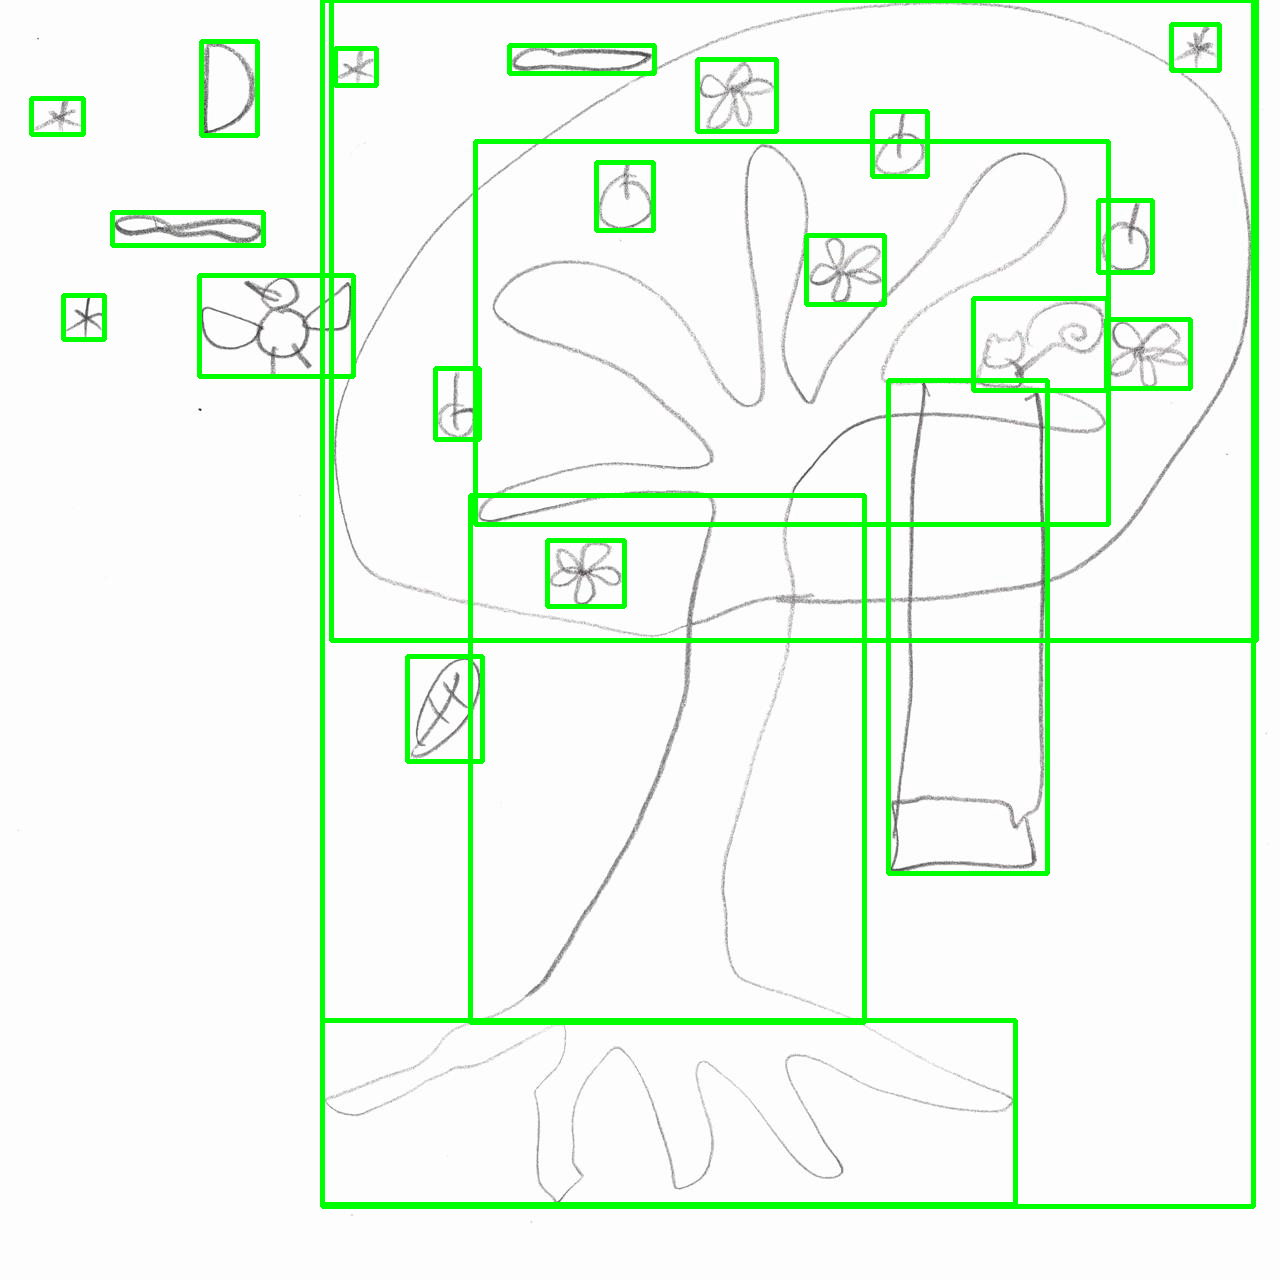

In [7]:
ex_img = train_images[0]
ex_label = train_labels[0]

def draw_bbox_on_image(image, label):
    image = cv2.imread(image, cv2.COLOR_BGR2RGB)
    label = json.load(open(label, 'r'))
    
    bbox = label['annotations']['bbox']
    for box in bbox:
        x = int(box['x'])
        y = int(box['y'])
        w = int(box['w'])
        h = int(box['h'])
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)
    return image
    
drawing = draw_bbox_on_image(ex_img, ex_label)
drawing = Image.fromarray(drawing)
drawing.show()

#### Rename File name to English

In [8]:
def numbering_files(path_list):
    counter = 0
    for i in tqdm(range(len(path_list))):
        path = path_list[i]
        path_tokens = path.split('/')
        filename = path_tokens[-1]
        filename_tokens = filename.split('.')
        counter += 1
        new_filename = str(counter).zfill(6) + '.' + filename_tokens[-1]
        new_path = os.path.join('/'.join(path_tokens[:-1]), new_filename)
        os.rename(path, new_path)

numbering_files(train_images)
numbering_files(valid_images)
numbering_files(train_labels)
numbering_files(valid_labels)

100%|██████████| 5600/5600 [00:00<00:00, 161545.73it/s]


#### modify labels format that is comparable with ultralytics YOLO

In [9]:
train_labels = sorted(glob.glob(label_path + '/train_json/*.json'))
valid_labels = sorted(glob.glob(label_path + '/valid_json/*.json'))

In [10]:
ex_label = train_labels[0]
with open(ex_label, 'r') as fr:
    label = json.load(fr)
label

{'meta': {'img_id': '나무_10_남_A116_jtg_20221021_12205392_0093',
  'contributor': 'A116',
  'date_created': '2022-11-24',
  'img_path': '../../원천데이터/나무/나무_10_남_00013.jpg',
  'label_path': './나무_10_남_00013.json',
  'img_size': 69253,
  'img_resolution': '1280x1280',
  'age': 10,
  'sex': '남'},
 'annotations': {'anno_id': 'y0xc0i2qagcwbgv83vsywf',
  'class': '나무',
  'bbox_count': 24,
  'bbox': [{'label': '나무전체', 'x': 322, 'y': 0, 'w': 931, 'h': 1206},
   {'label': '기둥', 'x': 470, 'y': 495, 'w': 394, 'h': 527},
   {'label': '수관', 'x': 331, 'y': 0, 'w': 925, 'h': 640},
   {'label': '가지', 'x': 475, 'y': 141, 'w': 633, 'h': 383},
   {'label': '뿌리', 'x': 322, 'y': 1020, 'w': 693, 'h': 184},
   {'label': '나뭇잎', 'x': 407, 'y': 656, 'w': 75, 'h': 105},
   {'label': '꽃', 'x': 547, 'y': 540, 'w': 77, 'h': 66},
   {'label': '꽃', 'x': 806, 'y': 235, 'w': 78, 'h': 69},
   {'label': '꽃', 'x': 697, 'y': 59, 'w': 79, 'h': 72},
   {'label': '꽃', 'x': 1106, 'y': 319, 'w': 84, 'h': 69},
   {'label': '열매', 'x

In [11]:
def collect_label_info(path_list):
    img_shape = defaultdict(int)
    age = defaultdict(int)
    sex = defaultdict(int)
    box_count = defaultdict(int)
    cls = defaultdict(int) # higher-level classes (one of ['man', 'woman', 'tree', 'house'])
    box_cls = defaultdict(int) # all classes of bbox
    
    for i in tqdm(range(len(path_list))):
        path = path_list[i]
        with open(path, 'r') as fr:
            label = json.load(fr)
        
        img_shape[label['meta']['img_resolution']] += 1
        age[label['meta']['age']] += 1
        sex[label['meta']['sex']] += 1
        
        annotation = label['annotations']
        box_count[annotation['bbox_count']] += 1
        cls[annotation['class']] += 1
        
        box_annotation = annotation['bbox']
        for box in box_annotation:
            box_cls[box['label']] += 1
            
    return img_shape, age, sex, box_count, cls, box_cls    

In [12]:
label_info = collect_label_info(train_labels)

100%|██████████| 44800/44800 [00:04<00:00, 9950.52it/s] 


In [13]:
print("img shape: ", label_info[0])
print("age: ", label_info[1])
print("sex: ", label_info[2])
print("box count: ", label_info[3])
print("cls: ", label_info[4])
print("box_cls: ", label_info[5])

img shape:  defaultdict(<class 'int'>, {'1280x1280': 44800})
age:  defaultdict(<class 'int'>, {10: 7350, 11: 8748, 12: 9862, 13: 8911, 7: 449, 8: 4487, 9: 4993})
sex:  defaultdict(<class 'int'>, {'남': 23477, '여': 21323})
box count:  defaultdict(<class 'int'>, {24: 1144, 25: 1104, 21: 1859, 17: 2129, 15: 832, 20: 1990, 23: 1294, 26: 5500, 28: 1564, 22: 1617, 16: 1479, 30: 403, 18: 2296, 19: 2226, 37: 86, 14: 259, 39: 57, 38: 81, 29: 916, 73: 1, 27: 16452, 36: 103, 31: 308, 42: 42, 32: 236, 35: 124, 34: 164, 44: 21, 33: 201, 116: 1, 45: 24, 46: 19, 57: 3, 41: 46, 62: 5, 48: 18, 40: 38, 51: 10, 56: 4, 49: 5, 59: 5, 50: 9, 67: 3, 47: 17, 52: 10, 78: 4, 43: 36, 75: 1, 63: 4, 64: 1, 53: 6, 71: 4, 58: 4, 55: 5, 61: 5, 101: 1, 136: 1, 130: 1, 84: 1, 128: 1, 154: 1, 54: 4, 125: 1, 69: 1, 140: 1, 66: 1, 65: 2, 109: 1, 68: 2, 83: 1, 97: 2, 74: 1, 93: 1, 95: 1})
cls:  defaultdict(<class 'int'>, {'나무': 11200, '남자사람': 11200, '여자사람': 11200, '집': 11200})
box_cls:  defaultdict(<class 'int'>, {'나무전체': 1

EDA

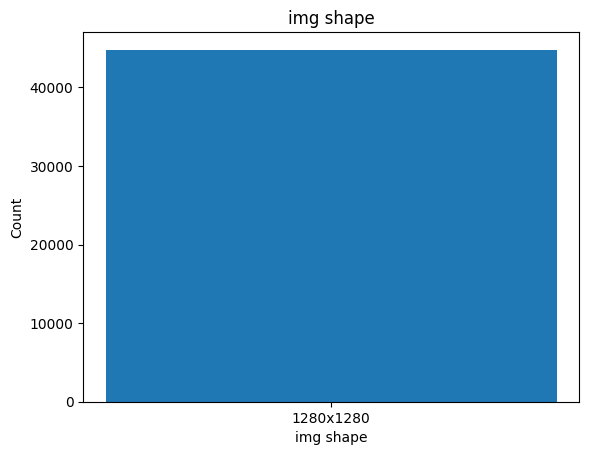

In [14]:
img_shape = list(label_info[0].keys())
img_shape_freq = list(label_info[0].values())
plt.bar(img_shape, img_shape_freq)
plt.title('img shape')
plt.xlabel('img shape')
plt.ylabel('Count')
plt.show()

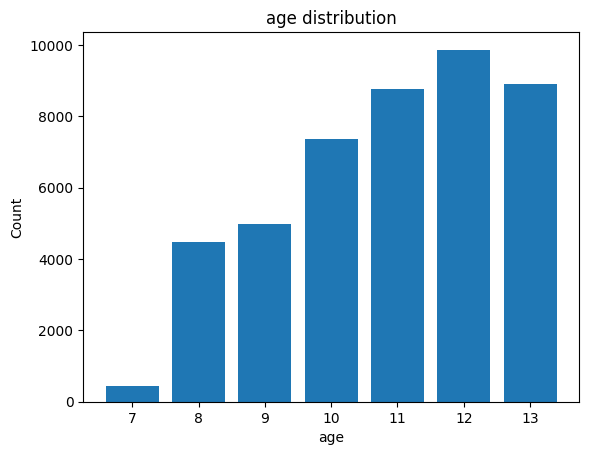

In [15]:
age = list(label_info[1].keys())
age_freq = list(label_info[1].values())
plt.bar(age, age_freq)
plt.title('age distribution')
plt.xlabel('age')
plt.ylabel('Count')
plt.show()

In [16]:
label_info[2].keys()

dict_keys(['남', '여'])

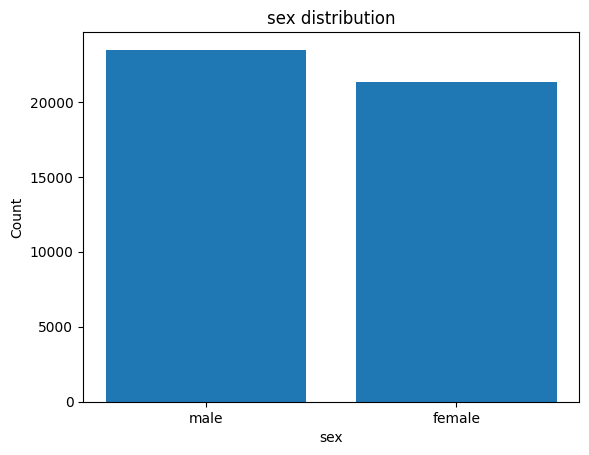

In [17]:
kor2eng = {'남': 'male', '여': 'female'}
sex = [kor2eng[k] for k in label_info[2].keys()]
sex_freq = list(label_info[2].values())
plt.bar(sex, sex_freq)
plt.title('sex distribution')
plt.xlabel('sex')
plt.ylabel('Count')
plt.show()

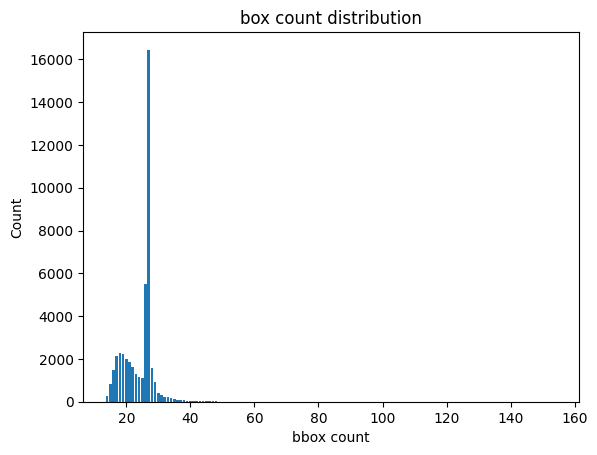

In [18]:
box_count = list(label_info[3].keys())
box_count_freq = list(label_info[3].values())
plt.bar(box_count, box_count_freq)
plt.title('box count distribution')
plt.xlabel('bbox count')
plt.ylabel('Count')
plt.show()

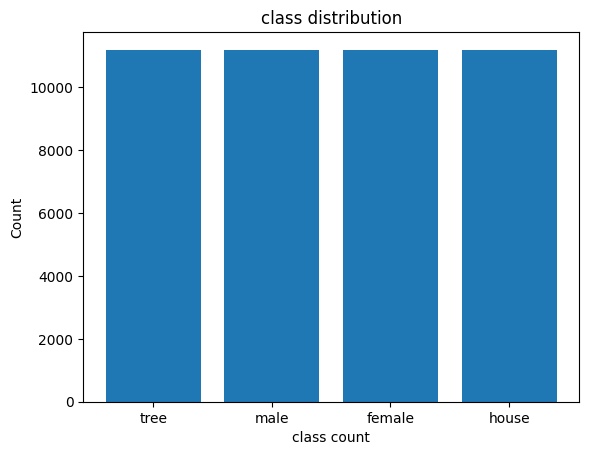

In [19]:
kor2eng_cls = {'남자사람': 'male', '여자사람': 'female', '나무': 'tree', '집': 'house'}
cls = [kor2eng_cls[k] for k in label_info[4].keys()]
cls_freq = list(label_info[4].values())
plt.bar(cls, cls_freq)
plt.title('class distribution')
plt.xlabel('class count')
plt.ylabel('Count')
plt.show()

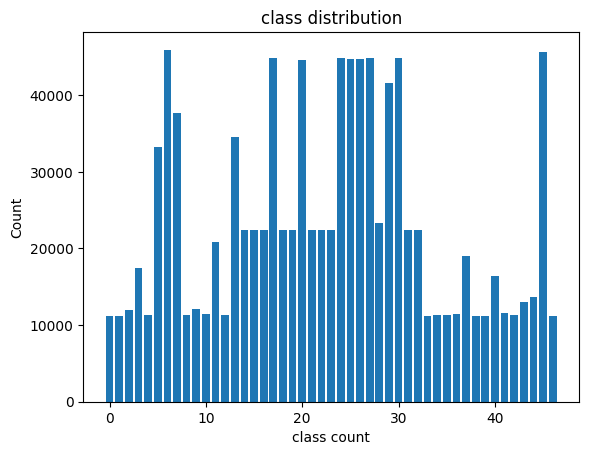

In [20]:
bcls = [i for i, k in enumerate(label_info[5].keys())]
bcls_freq = list(label_info[5].values())
plt.bar(bcls, bcls_freq)
plt.title('class distribution')
plt.xlabel('class count')
plt.ylabel('Count')
plt.show()

bbox visualization

In [21]:
ex_label = train_labels[0]
with open(ex_label, 'r') as fr:
    label = json.load(fr)
label

{'meta': {'img_id': '나무_10_남_A116_jtg_20221021_12205392_0093',
  'contributor': 'A116',
  'date_created': '2022-11-24',
  'img_path': '../../원천데이터/나무/나무_10_남_00013.jpg',
  'label_path': './나무_10_남_00013.json',
  'img_size': 69253,
  'img_resolution': '1280x1280',
  'age': 10,
  'sex': '남'},
 'annotations': {'anno_id': 'y0xc0i2qagcwbgv83vsywf',
  'class': '나무',
  'bbox_count': 24,
  'bbox': [{'label': '나무전체', 'x': 322, 'y': 0, 'w': 931, 'h': 1206},
   {'label': '기둥', 'x': 470, 'y': 495, 'w': 394, 'h': 527},
   {'label': '수관', 'x': 331, 'y': 0, 'w': 925, 'h': 640},
   {'label': '가지', 'x': 475, 'y': 141, 'w': 633, 'h': 383},
   {'label': '뿌리', 'x': 322, 'y': 1020, 'w': 693, 'h': 184},
   {'label': '나뭇잎', 'x': 407, 'y': 656, 'w': 75, 'h': 105},
   {'label': '꽃', 'x': 547, 'y': 540, 'w': 77, 'h': 66},
   {'label': '꽃', 'x': 806, 'y': 235, 'w': 78, 'h': 69},
   {'label': '꽃', 'x': 697, 'y': 59, 'w': 79, 'h': 72},
   {'label': '꽃', 'x': 1106, 'y': 319, 'w': 84, 'h': 69},
   {'label': '열매', 'x

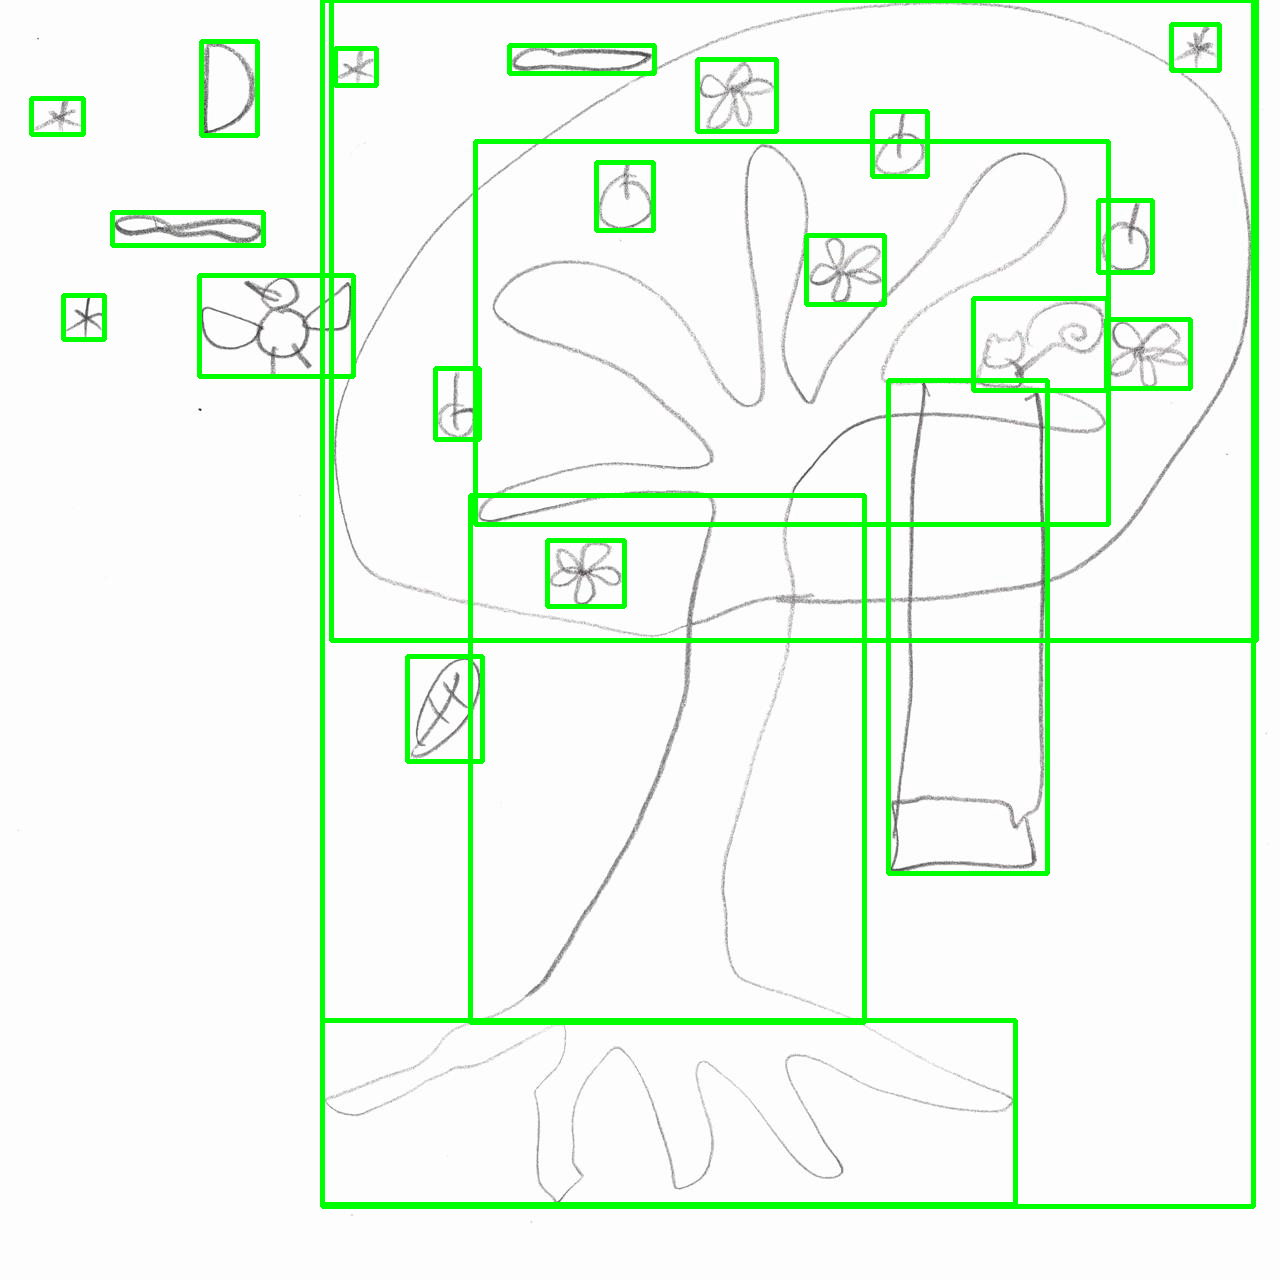

In [ ]:
train_images = sorted(glob.glob(image_path + '/train/*.jpg'))
valid_images = sorted(glob.glob(image_path + '/valid/*.jpg'))
train_labels = sorted(glob.glob(label_path + '/train_json/*.json'))
valid_labels = sorted(glob.glob(label_path + '/valid_json/*.json'))

ex_label = train_labels[0]
ex_img = train_images[0]

def draw_bbox_on_image(image, label):
    image = cv2.imread(image, cv2.COLOR_BGR2RGB)
    label = json.load(open(label, 'r'))
    
    bbox = label['annotations']['bbox']
    for box in bbox:
        x = int(box['x']) # format left-top point with height and width
        y = int(box['y'])
        w = int(box['w'])
        h = int(box['h'])
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)
    return image
    
drawing = draw_bbox_on_image(ex_img, ex_label)
drawing = Image.fromarray(drawing)
drawing.show()

In [24]:
# mapper dictionary that maps the class names to unique index
bcls2idx = {k : i for i, k in enumerate(sorted(label_info[5].keys()))}
print(bcls2idx)

{'가지': 0, '구름': 1, '굴뚝': 2, '귀': 3, '그네': 4, '기둥': 5, '길': 6, '꽃': 7, '나무': 8, '나무전체': 9, '나뭇잎': 10, '남자구두': 11, '눈': 12, '다람쥐': 13, '다리': 14, '단추': 15, '달': 16, '머리': 17, '머리카락': 18, '목': 19, '문': 20, '발': 21, '별': 22, '뿌리': 23, '사람전체': 24, '산': 25, '상체': 26, '새': 27, '손': 28, '수관': 29, '얼굴': 30, '여자구두': 31, '연기': 32, '연못': 33, '열매': 34, '운동화': 35, '울타리': 36, '입': 37, '잔디': 38, '주머니': 39, '지붕': 40, '집벽': 41, '집전체': 42, '창문': 43, '코': 44, '태양': 45, '팔': 46}


In [ ]:
o_train_label = label_path + '/train'
o_valid_label = label_path + '/valid'

def convert_to_yolo_format(path_list, bcls2idx, o_path):
    for i in tqdm(range(len(path_list))):
        path = path_list[i]
        with open(path, 'r') as fr:
            label = json.load(fr)
            
        annotation = label['annotations']
        box_annotation = annotation['bbox']
        img_size = (1280, 1280)
        write = ''
        for box in box_annotation:
            write += str(bcls2idx[box['label']]) + ' '
            write += str((box['x'] + box['w']//2) / img_size[0]) + ' '
            write += str((box['y'] + box['h']//2) / img_size[1]) + ' '
            write += str(box['w'] / img_size[0]) + ' '
            write += str(box['h'] / img_size[1]) + '\n'
        write = write[:-1]
        filename = path.split('/')[-1]
        new_path = os.path.join(o_path, filename.replace('.json', '.txt'))
        with open(new_path, 'w') as fw:
            fw.write(write)

convert_to_yolo_format(train_labels, bcls2idx, o_train_label)
convert_to_yolo_format(valid_labels, bcls2idx, o_valid_label)

train_labels = sorted(glob.glob(label_path + '/train/*.txt'))
valid_labels = sorted(glob.glob(label_path + '/valid/*.txt'))
print("number of train labels: ", len(train_labels))
print("number of valid labels: ", len(valid_labels))

number of train labels:  44800
number of valid labels:  5600
